# Image Classification in Deep Learning with PyTorch using Convolutional Neural Network, ResNet9 and Transfer Learning

Deep Learning is booming!

In this project, we will solve a **multiclass image classification** problem in Deep Learning which we could be tasked in real-world using the concepts of Neural Network and Transfer Learning with [PyTorch](https://pytorch.org/), a popular open-source neural networks framework.

We will build one simple deep **convolutional neural network (CNN)** and one with **ResNet9** architect then we will apply **Transfer Learning** to create a pre-trained ResNet34 model from PyTorch’s built-in models library.

![](https://miro.medium.com/max/700/1*oB3S5yHHhvougJkPXuc8og.gif)

In [1]:
import os
import torch

import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torchvision import models

from torch.utils.data import DataLoader
from torch.utils.data import random_split

import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Downloading the Dataset

The dataset is downloaded from Kaggle at: https://www.kaggle.com/puneet6060/intel-image-classification

This dataset contains around 25,000 images of natural scenes around the world, distributed under 6 categories and separated into training, testing and prediction sets.

First, we'll download the dataset then create PyTorch datasets to load the data.

### Download using `opendatasets` library

In [3]:
!pip install opendatasets --upgrade --q

In [ ]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/puneet6060/intel-image-classification'

od.download(dataset_url)

In [5]:
data_dir = 'intel-image-classification'
print(os.listdir(data_dir))

['seg_test', 'seg_pred', 'seg_train']


### Load from local drive

In [2]:
data_dir = 'data'
print(os.listdir(data_dir))

['seg_pred', 'seg_test', 'seg_train']


### Check the data

In [3]:
train_dir = data_dir + '/seg_train/seg_train/'
test_dir = data_dir + '/seg_test/seg_test/'

classes = os.listdir(train_dir)
classes.sort()
print(classes)

num_classes = len(classes)
print(num_classes)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
6


In [4]:
print("---Training Set---")
for cls in classes:
    print(f"{cls} : {len(os.listdir(train_dir + cls))}")

print("---Test Set---")
for cls in classes:
    print(f"{cls} : {len(os.listdir(test_dir + cls))}")

---Training Set---
buildings : 2191
forest : 2271
glacier : 2404
mountain : 2512
sea : 2274
street : 2382
---Test Set---
buildings : 437
forest : 474
glacier : 553
mountain : 525
sea : 510
street : 501


## Loading data into PyTorch

### Find means and standard deviations

Define `get_mean_and_std` function to calculate the means and standard deviations of the dataset that we will use to normalize.

In [ ]:
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in dataloader:
        # Mean over batch, height and width, but not over the channels (dim1)
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1
    
    mean = channels_sum / num_batches

    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

In [ ]:
tfms = T.Compose([T.Resize(128), 
                  T.CenterCrop(128), 
                  T.ToTensor()])

dataset = ImageFolder(train_dir, tfms)
dataloader = DataLoader(dataset, 128)

get_mean_and_std(dataloader)

# Mean: tensor([0.4302, 0.4574, 0.4537])
# Std: tensor([0.2580, 0.2562, 0.2884]))

(tensor([0.4302, 0.4574, 0.4537]), tensor([0.2580, 0.2562, 0.2884]))

torch.Size([3, 128, 128]) mountain


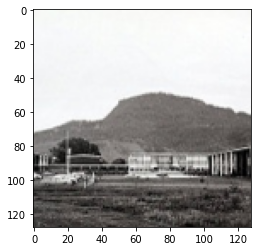

In [ ]:
img, label = dataset[0]
plt.imshow(img.permute((1, 2, 0)))
print(img.shape, classes[label])

### Load and transform

Load the data using `ImageFolder` with channel-wise data normalization & randomized data augmentations.

In [5]:
img_size = 64
mean = [0.4302, 0.4574, 0.4537]
std = [0.2580, 0.2562, 0.2884]
stats = mean, std

train_tfms = T.Compose([T.Resize(img_size),
                        T.RandomCrop(img_size), 
                        T.ToTensor(),
                        T.Normalize(*stats, inplace=True)])
test_tfms = T.Compose([T.Resize(img_size),
                        T.RandomCrop(img_size),
                        T.ToTensor(),
                        T.Normalize(*stats)])

dataset = ImageFolder(train_dir, train_tfms)
test_ds = ImageFolder(test_dir, test_tfms)

len(dataset), len(test_ds)

(14034, 3000)

Slit the dataset into `train_ds` for training and `valid_ds` for validaton using `random_split` function.

In [6]:
valid_size = int(0.2 * len(dataset))
train_size = len(dataset) - valid_size

train_ds, valid_ds = random_split(dataset, [train_size, valid_size])

len(train_ds), len(valid_ds)

(11228, 2806)

Create data loaders for retrieving images in batches with `batch_size`.

In [7]:
batch_size = 128

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=2, pin_memory=True)

Let's take a look at some sample images from the training dataloader. To display the images, we'll need to _denormalize_ the pixels values to bring them back into the range `(0,1)`.

In [8]:
def denormalize(images, means, stds):
    if len(images.shape) == 3:
      images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:batch_size], nrow=16).permute(1, 2, 0).clamp(0, 1))
        break

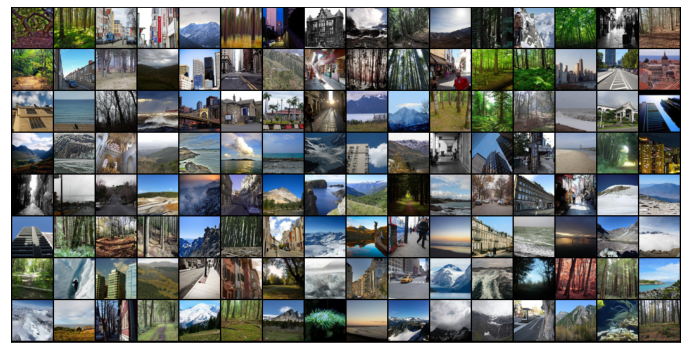

In [9]:
show_batch(train_dl)

## Utitilty Functions

### GPU utilities

- `get_default_device` to choose the `device` we'll use to train our models on (GPU if it is available, otherwise CPU is chosen)
- `to_device` to move tensors including our models to the `device`
- `DeviceDataLoader` to move dataloaders to the `device`

In [10]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [11]:
device = get_default_device()
device

device(type='cuda')

So our device is a GPU with the type `'cuda'`.

Now we transfer batches of data from our data loaders to the GPU using the predefined `DeviceDataLoader` function.

In [12]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

### Model utilities

In [13]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print(f"Epoch [{epoch}]: train_loss: {result['train_loss']:.4f}, val_loss: {result['val_loss']:.4f}, val_acc: {result['val_acc']:.4f}")


@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def conv_block(in_channels, out_channels, pool=0):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool:
      layers.append(nn.MaxPool2d(pool))
    return nn.Sequential(*layers)

### Result and testing

In [14]:
def plot_result(history):
    fig, ax1 = plt.subplots(figsize=(10, 6))
    plt.title("Result of Training Session")    
    
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    ax1.plot(train_losses, '-x', linewidth=0.5)
    ax1.plot(val_losses, '-cx', linewidth=0.5)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'], loc='center right')

    ax2 = ax1.twinx()
    accuracies = [x['val_acc'] for x in history]
    ax2.plot(accuracies, marker='o', color='r')
    ax2.set_ylabel('accuracy', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    plt.show()

In [15]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return preds[0].item()
    # dataset.classes[preds[0].item()]

def show_image_prediction(img, label, model):
    plt.imshow(denormalize(img, *stats)[0].permute((1, 2, 0)).clamp(0, 1))
    pred = predict_image(img, model)
    print('Target:', classes[label])
    print('Prediction:', classes[pred])

In [16]:
def cfs_mat(model):
    labels, preds = [], []
    for i in range(len(test_ds)):
        img, label = test_ds[i]
        labels.append(label)
        preds.append(predict_image(img, model))
    sns.heatmap(confusion_matrix(labels, preds), cmap='YlGnBu', 
                xticklabels=classes, yticklabels=classes, annot=True)


In [17]:
model_results = {'model': [],
                 'val_acc': []}

## Convolutional Neural Network

### Construct the model and define `fit` function

First, we'll construct a simple CNN model with 3 `conv_block` and a linear layer.

In [18]:
class CNN(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            conv_block(in_channels, 32), # out: 32*64*64

            conv_block(32, 64, pool=4),  # 64*16*16
            conv_block(64, 128, pool=4), # 128*4*4

            nn.AdaptiveMaxPool2d(1),     # 128*1*1
            nn.Flatten(),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, batch):
        return self.network(batch)

Define `fit` function for training.

In [19]:
def fit(model, train_loader, val_loader, 
        epochs, lr, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), lr)
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

### Training Process

Load the model to GPU.

In [20]:
model_CNN = to_device(CNN(3, num_classes), device)

Evaluate initial accuracy.

In [21]:
history_CNN = [evaluate(model_CNN, valid_dl)]
history_CNN

[{'val_loss': 1.7994074821472168, 'val_acc': 0.16029193997383118}]

Begin the trainning process.

In [22]:
# Run 1
epochs = 5
lr = 5e-2
# opt_func = None (using the default SGD)

history_CNN += fit(model_CNN, train_dl, valid_dl, epochs, lr)

Epoch [0]: train_loss: 1.4732, val_loss: 0.9924, val_acc: 0.6134
Epoch [1]: train_loss: 0.9932, val_loss: 1.3868, val_acc: 0.5344
Epoch [2]: train_loss: 0.8390, val_loss: 0.9793, val_acc: 0.6329
Epoch [3]: train_loss: 0.7777, val_loss: 0.6885, val_acc: 0.7538
Epoch [4]: train_loss: 0.7047, val_loss: 0.6658, val_acc: 0.7506


In [23]:
# Run 2
epochs = 5
lr = 5e-3
# opt_func = None (using the default SGD)

history_CNN += fit(model_CNN, train_dl, valid_dl, epochs, lr)

Epoch [0]: train_loss: 0.5051, val_loss: 0.5624, val_acc: 0.8019
Epoch [1]: train_loss: 0.4815, val_loss: 0.5470, val_acc: 0.8057
Epoch [2]: train_loss: 0.4731, val_loss: 0.5419, val_acc: 0.8068
Epoch [3]: train_loss: 0.4653, val_loss: 0.5374, val_acc: 0.8072
Epoch [4]: train_loss: 0.4557, val_loss: 0.5356, val_acc: 0.8087


In [24]:
# Run 3
epochs = 5
lr = 5e-4
# opt_func = None (using the default SGD)

history_CNN += fit(model_CNN, train_dl, valid_dl, epochs, lr)

Epoch [0]: train_loss: 0.4490, val_loss: 0.5311, val_acc: 0.8087
Epoch [1]: train_loss: 0.4467, val_loss: 0.5288, val_acc: 0.8111
Epoch [2]: train_loss: 0.4458, val_loss: 0.5267, val_acc: 0.8125
Epoch [3]: train_loss: 0.4446, val_loss: 0.5266, val_acc: 0.8136
Epoch [4]: train_loss: 0.4426, val_loss: 0.5248, val_acc: 0.8146


Plot the traing results.

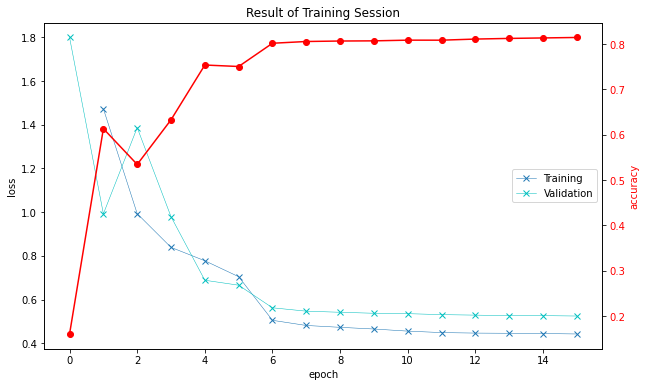

In [25]:
plot_result(history_CNN)

### Test the model

First, let's test our model with some invidiual images.

Target: buildings
Prediction: buildings


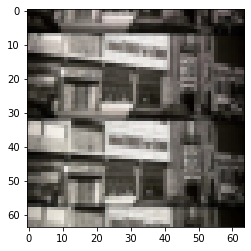

In [26]:
# Test 1
show_image_prediction(*test_ds[300], model_CNN)

Target: forest
Prediction: forest


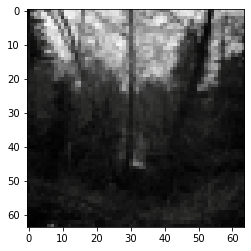

In [27]:
# Test 2
show_image_prediction(*test_ds[900], model_CNN)

Target: sea
Prediction: sea


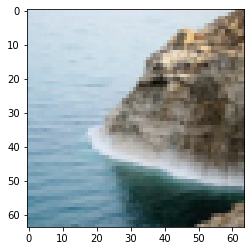

In [28]:
# Test 3
show_image_prediction(*test_ds[2100], model_CNN)

Finally, evaluate the model with the entire test set.

In [29]:
test_dl = DeviceDataLoader(DataLoader(test_ds, batch_size*2, num_workers=2), device)

result_CNN = evaluate(model_CNN, test_dl)
result_CNN

{'val_loss': 0.508938729763031, 'val_acc': 0.8250820636749268}

Confusion Matrix

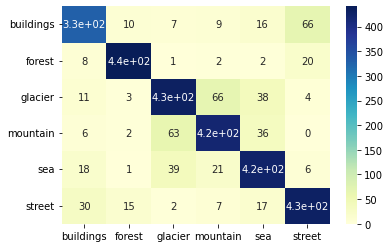

In [30]:
cfs_mat(model_CNN)

### Record result and save the model

In [31]:
model_results['model'].append('CNN')
model_results['val_acc'].append(result_CNN['val_acc'])
torch.save(model_CNN.state_dict(), 'intel_image-cnn.pth')

## ResNet9

### Construct the model

We will use the ResNet9 architecture to build our main model.

![resnet-9](https://github.com/lambdal/cifar10-fast/raw/master/net.svg?sanitize=true)

In [32]:
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        #prep
        self.conv1 = conv_block(in_channels, 32)     # out: 32*64*64

        #layer1
        self.conv2 = conv_block(32, 64, pool=2)      # 64*32*32
        self.res1 = nn.Sequential(conv_block(64, 64), 
                                  conv_block(64, 64))
        
        #layer 2
        self.conv3 = conv_block(64, 128, pool=2)     # 128*16*16

        #layer 3
        self.conv4 = conv_block(128, 256, pool=2)    # 256*8*8
        self.res2 = nn.Sequential(conv_block(256, 256), 
                                  conv_block(256, 256))
        
        #classifier
        self.clf = nn.Sequential(nn.AdaptiveMaxPool2d(1), # 256*1*1
                                 nn.Flatten(), 
                                 nn.Dropout(0.2), 
                                 nn.Linear(256, num_classes))
        
    def forward(self, batch):
        out = self.conv1(batch)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.clf(out)
        return out

Instead of using previous `fit` function, we will upgrade it to `fit_one_cycle` function with some small yet important improvements:

- **Learning rate scheduler** (`lr_sched`): Instead of using a fixed learning rate, we will use a learning rate scheduler called [**One Cycle Learning Rate Policy**](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.OneCycleLR.html#torch.optim.lr_scheduler.OneCycleLR), which will change the learning rate after every batch of training by starting with a low learning rate, gradually increasing it batch-by-batch to a high learning rate for about 30% of epochs, then gradually decreasing it to a very low value for the remaining epochs.

- **Weight decay** (`weight_decay`): We also use weight decay which prevents the weights from becoming too large by adding an additional term to the loss function.

- **Gradient clipping** (`grad_clip`): Gradient clipping is a simple yet effective technique which helps to limit the values of gradients to a small range to prevent undesirable changes in parameters due to large gradient values.

In [33]:
def fit_one_cycle(model, train_loader, val_loader, 
                  epochs, max_lr, opt_func=torch.optim.SGD, 
                  grad_clip=None, weight_decay=0):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    lr_sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                   steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []

        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Update learning rate
            lr_sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

### Training Process

In [34]:
model_RN9 = to_device(ResNet9(3, num_classes), device)

In [35]:
history_RN9 = [evaluate(model_RN9, valid_dl)]
history_RN9

[{'val_loss': 1.7949209213256836, 'val_acc': 0.1546967327594757}]

In [36]:
# Run 1
epochs = 10
max_lr = 5e-3
opt_func = torch.optim.Adam
grad_clip = 0.05
weight_decay = 1e-4

history_RN9 += fit_one_cycle(model_RN9, train_dl, valid_dl, 
                             epochs, max_lr, opt_func, 
                             grad_clip, weight_decay)

Epoch [0]: train_loss: 1.0778, val_loss: 0.8700, val_acc: 0.6973
Epoch [1]: train_loss: 0.7233, val_loss: 1.3221, val_acc: 0.6297
Epoch [2]: train_loss: 0.6545, val_loss: 0.5656, val_acc: 0.7905
Epoch [3]: train_loss: 0.6024, val_loss: 0.7297, val_acc: 0.7346
Epoch [4]: train_loss: 0.4867, val_loss: 0.5953, val_acc: 0.8015
Epoch [5]: train_loss: 0.4022, val_loss: 0.7690, val_acc: 0.7469
Epoch [6]: train_loss: 0.3417, val_loss: 0.3737, val_acc: 0.8668
Epoch [7]: train_loss: 0.2875, val_loss: 0.3260, val_acc: 0.8846
Epoch [8]: train_loss: 0.2229, val_loss: 0.3217, val_acc: 0.8889
Epoch [9]: train_loss: 0.1946, val_loss: 0.3103, val_acc: 0.8910


In [37]:
# Run 2
epochs = 10
max_lr = 5e-4
opt_func = torch.optim.Adam
grad_clip = 0.05
weight_decay = 1e-4

history_RN9 += fit_one_cycle(model_RN9, train_dl, valid_dl, 
                             epochs, max_lr, opt_func, 
                             grad_clip, weight_decay)

Epoch [0]: train_loss: 0.1893, val_loss: 0.3099, val_acc: 0.8900
Epoch [1]: train_loss: 0.2018, val_loss: 0.3272, val_acc: 0.8874
Epoch [2]: train_loss: 0.2117, val_loss: 0.3548, val_acc: 0.8813
Epoch [3]: train_loss: 0.2097, val_loss: 0.3503, val_acc: 0.8810
Epoch [4]: train_loss: 0.1713, val_loss: 0.3329, val_acc: 0.8906
Epoch [5]: train_loss: 0.1394, val_loss: 0.3409, val_acc: 0.8888
Epoch [6]: train_loss: 0.1122, val_loss: 0.3263, val_acc: 0.8938
Epoch [7]: train_loss: 0.0850, val_loss: 0.3226, val_acc: 0.8917
Epoch [8]: train_loss: 0.0699, val_loss: 0.3024, val_acc: 0.9056
Epoch [9]: train_loss: 0.0642, val_loss: 0.3071, val_acc: 0.9056


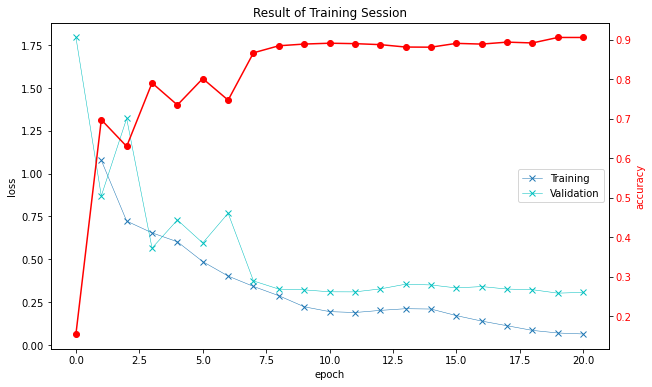

In [38]:
plot_result(history_RN9)

### Test the model

First, let's test with some invidiual images.

Target: forest
Prediction: forest


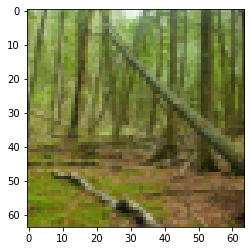

In [39]:
# Test 1
show_image_prediction(*test_ds[600], model_RN9)

Target: glacier
Prediction: glacier


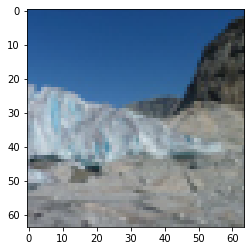

In [40]:
# Test 2
show_image_prediction(*test_ds[1200], model_RN9)

Target: sea
Prediction: sea


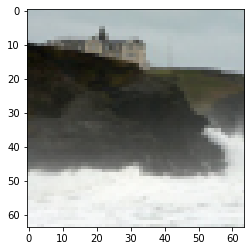

In [41]:
# Test 3
show_image_prediction(*test_ds[2400], model_RN9)

Finally, evaluate the model with the entire test set.

In [42]:
test_dl = DeviceDataLoader(DataLoader(test_ds, batch_size*2, num_workers=2), device)

result_RN9 = evaluate(model_RN9, test_dl)
result_RN9

{'val_loss': 0.30517837405204773, 'val_acc': 0.9062216877937317}

Confusion Matrix

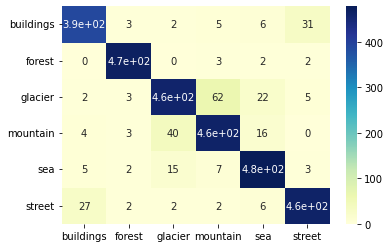

In [43]:
cfs_mat(model_RN9)

### Record result and save the model

In [44]:
model_results['model'].append('ResNet9')
model_results['val_acc'].append(result_RN9['val_acc'])
torch.save(model_CNN.state_dict(), 'intel_image-resnet9.pth')

## Transfer Learning

Import a pre-trained ResNet34 model from PyTorch built-in models.

In [45]:
class ResNet34(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=False):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, batch):
        return self.network(batch)

In [ ]:
model_RN34 = to_device(ResNet34(num_classes, pretrained=True), device)

In [47]:
history_RN34 = [evaluate(model_RN34, valid_dl)]
history_RN34

[{'val_loss': 2.5786538124084473, 'val_acc': 0.08665350079536438}]

In [48]:
# Run 1
epochs = 10
max_lr = 5e-4
opt_func = torch.optim.Adam
# grad_clip = 0.05
# weight_decay = 1e-4

history_RN34 += fit_one_cycle(model_RN34, train_dl, valid_dl, 
                              epochs, max_lr, opt_func, 
                              grad_clip, weight_decay)

Epoch [0]: train_loss: 0.8314, val_loss: 0.3718, val_acc: 0.8732
Epoch [1]: train_loss: 0.2564, val_loss: 0.4108, val_acc: 0.8718
Epoch [2]: train_loss: 0.2268, val_loss: 0.3960, val_acc: 0.8746
Epoch [3]: train_loss: 0.1625, val_loss: 0.4156, val_acc: 0.8811
Epoch [4]: train_loss: 0.1047, val_loss: 0.3760, val_acc: 0.8957
Epoch [5]: train_loss: 0.0525, val_loss: 0.3812, val_acc: 0.9006
Epoch [6]: train_loss: 0.0204, val_loss: 0.4041, val_acc: 0.9059
Epoch [7]: train_loss: 0.0073, val_loss: 0.4118, val_acc: 0.9085
Epoch [8]: train_loss: 0.0030, val_loss: 0.4150, val_acc: 0.9142
Epoch [9]: train_loss: 0.0021, val_loss: 0.4129, val_acc: 0.9131


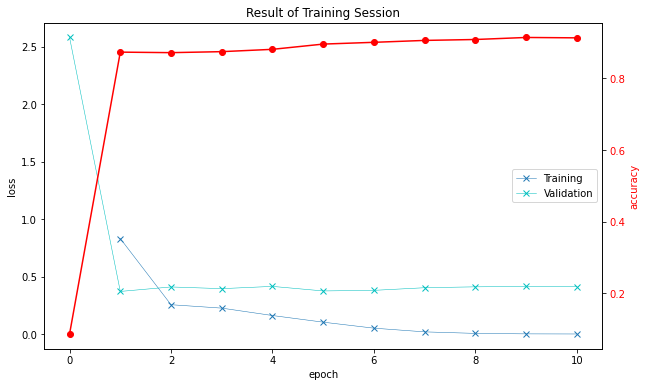

In [49]:
plot_result(history_RN34)

In [50]:
test_dl = DeviceDataLoader(DataLoader(test_ds, batch_size*2, num_workers=2), device)

result_RN34 = evaluate(model_RN34, test_dl)
result_RN34

{'val_loss': 0.38464078307151794, 'val_acc': 0.9162278771400452}

In [51]:
model_results['model'].append('ResNet34')
model_results['val_acc'].append(result_RN34['val_acc'])
torch.save(model_RN34.state_dict(), 'intel_image-resnet34.pth')

## Conclusion

Let's take a look at the performances of our models we built through this project.

In [52]:
results_df = pd.DataFrame(model_results)
results_df

,model,val_acc
0,CNN,0.825082
1,ResNet9,0.906222
2,ResNet34,0.916228


So whereas the simple CNN model kind of under-performed with acurracy of 82.5%, which is understandable, we did a pretty good job when our built-from-scratch ResNet9 with accuarcy of **90.6%** is almost as good as the pre-trained ResNet34 model with accuarcy of 91.6%.

## References

1. [Jovian's Zero to GANs Deep Learning with PyTorch Course](https://jovian.ai/learn/deep-learning-with-pytorch-zero-to-gans)
2. [PyTorch's documentation](https://pytorch.org/docs/stable/index.html)